In [ ]:
import os
os.environ['SETIGEN_ENABLE_GPU'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from astropy import units as u
import blimpy as bl

import setigen as stg

In [2]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

In [ ]:
num_pols = 2
sample_rate = 3e9
num_taps = 8
num_branches = 1024
chan_bw = sample_rate / num_branches

# Antenna
antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=4*u.GHz,
                              ascending=True,
                              num_pols=num_pols)

# Backend components
digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

requantizer = stg.voltage.ComplexQuantizer(target_fwhm=32,
                                           num_bits=8)

rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=0,
                                    num_chans=64,
                                    block_size=134217728,
                                    blocks_per_file=128,
                                    num_subblocks=32)

fftlength = 1048576
int_factor = 51

# Compute relevant quantities with helper functions above
unit_drift_rate = stg.get_unit_drift_rate(rvb, fftlength, int_factor)
signal_level = stg.get_intensity(10, rvb, fftlength, int_factor)

for stream in antenna.streams:
    stream.add_noise(v_mean=0, 
                     v_std=1)
    
    stream.add_constant_signal(f_start=chan_bw / fftlength * int(fftlength*(2+0.3-0.5)), 
                      drift_rate=0*u.Hz/u.s, 
                      level=signal_level)


# Record to file
rvb.record(raw_file_stem='/datax/scratch/bbrzycki/data/raw_files/test_snr_actual_5min',
           obs_length=300, 
           length_mode='obs_length',
           header_dict={'TELESCOP': 'GBT'})


In [3]:
num_taps = 8
num_branches = 1024
fftlength = 1048576
filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

In [4]:
x = filterbank.get_response(fftlength)
x

In [4]:
filterbank.window

array([-7.83350901e-05, -2.35062326e-04, -3.91865779e-04, ...,
       -3.91865779e-04, -2.35062326e-04, -7.83350901e-05])

In [5]:
filterbank.window.shape

(8192,)

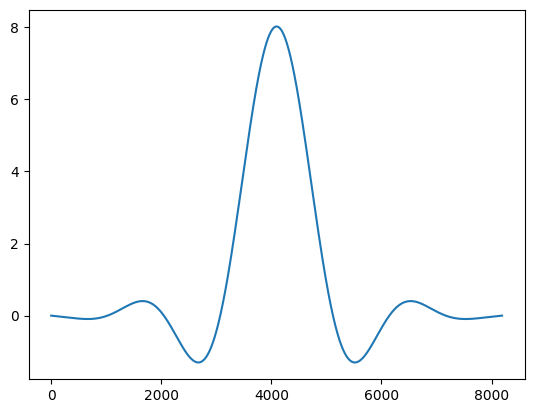

In [6]:
plt.plot(filterbank.window)
plt.show()

In [8]:
x = filterbank.get_response(8)
x.shape

(4,)

(2048,)


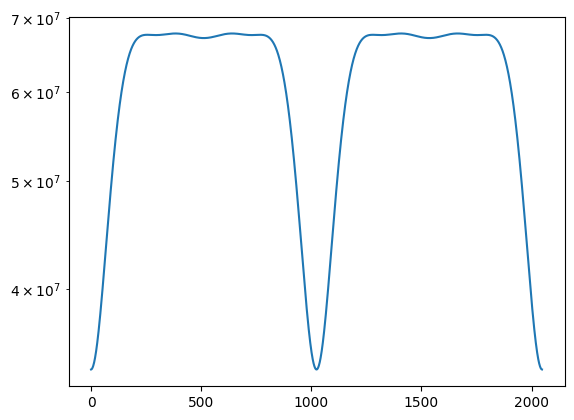

In [32]:
x = filterbank.tile_response(num_chans=2, fftlength=1024)
print(x.shape)
plt.plot(x)
plt.yscale('log')
plt.show()